In [1]:
import cppchess as chess
from mcts.c import run_mcts
import tensorflow as tf
from game import Game
from config import Config
import numpy as np

2024-04-25 13:08:53.307036: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Testing bot vs random move

In [2]:
#model_name = "r6c64Ad1e-4L2b64"
model_name = "test"
model_path = f"models/{model_name}/saved_model"
model = tf.saved_model.load(model_path)
trt_func = model.signatures["serving_default"]

2024-02-27 10:59:15.432708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5823 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5


In [3]:
NUM_GAMES = 1
BOT_COLOR = chess.WHITE
ALTERNATE_COLORS = True
config = Config()
results = {
    model_name: 0,
    "Opponent": 0,
}
for _ in range(NUM_GAMES):
    board = chess.Board()
    game = Game(board)
    while not game.terminal_with_outcome():
        if game.to_play() == BOT_COLOR:
            move, _ = run_mcts(
                game=game,
                config=config,
                network=trt_func,
                root=None,
                reuse_tree=False,
                num_simulations=config.num_mcts_sims,
                num_sampling_moves=0,
                add_noise=False,
                pb_c_factor=1.5,
            )
        else:
            move = np.random.default_rng().choice(game.legal_moves())
        game.make_move(move)
    print(game.outcome_str)
    if game.terminal_value(BOT_COLOR) == 1:
        results[model_name] += 1
    elif game.terminal_value(BOT_COLOR) == -1:
        results["Opponent"] += 1
    else:
        results[model_name] += 0.5
        results["Opponent"] += 0.5
    if ALTERNATE_COLORS:
        BOT_COLOR = not BOT_COLOR
print(results)

2024-02-27 10:59:22.443594: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2024-02-27 10:59:22.443661: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2024-02-27 10:59:27.897508: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1329] [TF-TRT] Sparse compute capability: enabled.


White wins: outcome=Checkmate
{'test': 1, 'Opponent': 0}


## Testing Bot vs Other bot

In [1]:
import cppchess as chess
from mcts.c import run_mcts
from game import Game
from config import Config

model1_name = "r4c48Ad1e-5L2b64"
#model2_name = "r4c48Ad1e-4L2b64"
model2_name = "test"

2024-03-01 12:08:11.411458: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from multiprocessing import Manager, Process

def play_game(name, color, num_games, alternate_colors, history, results, barrier):
    import tensorflow as tf
    gpu_devices = tf.config.experimental.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)

    model_path = f"models/{name}/saved_model"
    model = tf.saved_model.load(model_path)
    trt_func = model.signatures["serving_default"]
    
    for i in range(num_games):
        config = Config()
        board = chess.Board()
        game = Game(board)
        while not game.terminal_with_outcome():
            if game.to_play() == color:
                move, _ = run_mcts(
                    game=game,
                    config=config,
                    network=trt_func,
                    root=None,
                    reuse_tree=False,
                    num_simulations= 600, #config.num_mcts_sims,
                    num_sampling_moves=config.num_mcts_sampling_moves,
                    add_noise=config.add_dirichlet_noise,
                    pb_c_factor=config.pb_c_factor,
                )
                history[i].append(move)
            barrier.wait()
            game.make_move(history[i][-1])

        if game.terminal_value(color) == 1:
            results[name] += 1
        elif game.terminal_value(color) != -1:
            results[name] += 0.5
        if alternate_colors:
            color = not color

if __name__ == "__main__":
    NUM_GAMES = 20
    ALTERNATE_COLORS = True
    with Manager() as manager:
        barrier = manager.Barrier(2)
        history = manager.list()
        for _ in range(NUM_GAMES):
            history.append(manager.list())
        results = manager.dict({
            model1_name: 0,
            model2_name: 0,
        })
        p1 = Process(target=play_game, args=(model1_name, chess.WHITE, NUM_GAMES, ALTERNATE_COLORS, history, results, barrier))
        p2 = Process(target=play_game, args=(model2_name, chess.BLACK, NUM_GAMES, ALTERNATE_COLORS, history, results, barrier))
        p1.start()
        p2.start()
        p1.join()
        p2.join()
        print(results)


2024-03-01 08:49:54.075402: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5959 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5
2024-03-01 08:49:54.075407: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5959 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5
2024-03-01 08:49:56.915209: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2024-03-01 08:49:56.923441: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2024-03-01 08:50:02.602346: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1329] [TF-TRT] Sparse compute capability: enabled.
2024-03-01 08:50:32.789663: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT

{'r4c48Ad1e-5L2b64': 12.5, 'test': 7.5}


## Playing vs bot

In [1]:
import chess
import cppchess as cchess
from game import Game
from mcts.c import run_mcts
from config import Config
from trt_funcs import load_trt_checkpoint_latest

trt_func, model = load_trt_checkpoint_latest()



2024-05-14 21:42:57.966947: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 21:42:59.382993: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6141 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5
2024-05-14 21:42:59.613816: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


In [5]:
config = Config()
game = Game(cchess.Board())
root = None

In [8]:
player = chess.BLACK

In [13]:
if root:
    root = root[move]

if game.to_play() == player:
    move = input("Enter move: ")
    game.make_move(move)
else:
    move, root, visit_counts = run_mcts(
        game,
        config,
        trt_func, 
        num_simulations=config.num_mcts_sims, 
        time_limit=10.0,#config.time_limit,
        root=None,
        verbose_move=True,
        engine_play=True)
    game.make_move(move)


fen = f"{game.board}"
board = chess.Board(fen=fen)
board
#game.board

In [12]:
root["g6g7"].display_move_statistics()

Visits: 1
Value: 1.000000
Evaluation: 0.431602
Move          Visits  NN Output                    Policy             Prior          Avg. value     UCB            Q+U           
----------------------------------------------------------------------------------------------------------------------------------
e8e7  (None)  N: 0    (v: 0.000000, p:  10.651523)  (p_norm: 100.00%)  (P: 1.000000)  (Q: 1.000000)  (U: 0.000000)  (Q+U: 1.000000)


#### Test positions

In [1]:
import chess
#import cppchess as cchess
from game import Game
from mcts import run_mcts
from config import Config
from trt_funcs import load_trt_checkpoint_latest
from test_games import ruy_lopez, scholars_mate

trt_func, model = load_trt_checkpoint_latest()

2024-05-14 09:50:18.360228: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 09:50:19.721330: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5
2024-05-14 09:50:19.926610: E tensorflow/compiler/tf2tensorrt/utils/trt_logger.cc:87] DefaultLogger 3: [runtime.cpp::~Runtime::346] Error Code 3: API Usage Error (Parameter check failed at: runtime/rt/runtime.cpp::~Runtime::346, condition: mEngineCounter.use_count() == 1. Destroying a runtime before destroying deserialized engines created by the runtime leads to undefined behavior.
)


In [2]:
game = Game(chess.Board())
config = Config()

In [121]:
#game = Game(scholars_mate)
if game.to_play():
    print("WHITE PLAYS")
else:
    print("BLACK PLAYS")
move, root, _ = run_mcts(
    game,
    config,
    trt_func, 
    num_simulations=1000, 
    time_limit=None,
    verbose_move=True,
    engine_play=False)

game.make_move(move)
#fen = f"{game.board}"
#board = chess.Board(fen=fen)
#board
game.board

BLACK PLAYS


ValueError: zero-size array to reduction operation maximum which has no identity

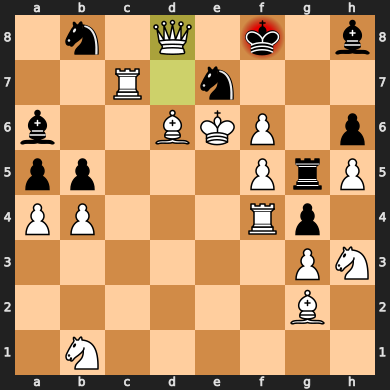

In [122]:
game.board


In [1]:
from train.model import generate_model

model = generate_model()

2024-05-13 17:26:04.279833: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 17:26:05.575992: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5934 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:26:00.0, compute capability: 7.5


In [2]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 83, 8, 8)]   0           []                               
                                                                                                  
 Body-Conv2D (Conv2D)           (None, 96, 8, 8)     71712       ['input_layer[0][0]']            
                                                                                                  
 Body-BatchNorm (BatchNormaliza  (None, 96, 8, 8)    384         ['Body-Conv2D[0][0]']            
 tion)                                                                                            
                                                                                                  
 Body-ReLU (ReLU)               (None, 96, 8, 8)     0           ['Body-BatchNorm[0][0]']     

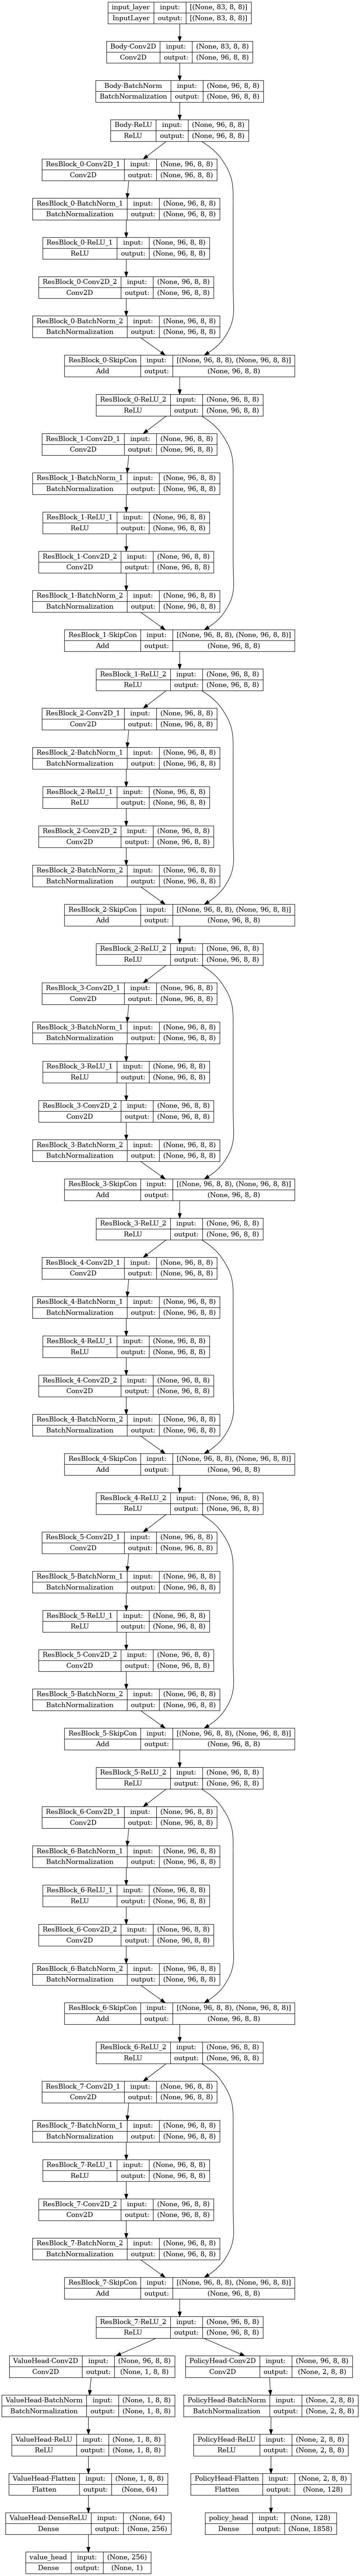

In [3]:
from keras.utils import plot_model
plot_model(model, to_file='model_n.png', show_shapes=True, show_layer_names=True)

In [19]:
from actionspace import map_w, map_b
import json

# Swap key and value
w_r = {v: k for k, v in map_w.items()}
b_r = {v: k for k, v in map_b.items()}

w_r = dict(sorted(w_r.items(), key=lambda item: item[0]))
b_r = dict(sorted(b_r.items(), key=lambda item: item[0]))

map_w2 = {v: k for k, v in enumerate(w_r.values())}
map_b2 = {v: k for k, v in enumerate(b_r.values())}

print(map_w2)
print(map_b2)

#Save to json files

with open("map_w.json", "w") as f:
    json.dump(map_w2, f)

with open("map_b.json", "w") as f:
    json.dump(map_b2, f) 

{'a1a2': 0, 'a1b2': 1, 'a1b1': 2, 'a1a3': 3, 'a1c3': 4, 'a1c1': 5, 'a1a4': 6, 'a1d4': 7, 'a1d1': 8, 'a1a5': 9, 'a1e5': 10, 'a1e1': 11, 'a1a6': 12, 'a1f6': 13, 'a1f1': 14, 'a1a7': 15, 'a1g7': 16, 'a1g1': 17, 'a1a8': 18, 'a1h8': 19, 'a1h1': 20, 'a1b3': 21, 'a1c2': 22, 'a2a3': 23, 'a2b3': 24, 'a2b2': 25, 'a2b1n': 26, 'a2a1n': 27, 'a2a4': 28, 'a2c4': 29, 'a2c2': 30, 'a2a5': 31, 'a2d5': 32, 'a2d2': 33, 'a2a6': 34, 'a2e6': 35, 'a2e2': 36, 'a2a7': 37, 'a2f7': 38, 'a2f2': 39, 'a2a8': 40, 'a2g8': 41, 'a2g2': 42, 'a2h2': 43, 'a2b4': 44, 'a2c3': 45, 'a2c1': 46, 'a3a4': 47, 'a3b4': 48, 'a3b3': 49, 'a3b2': 50, 'a3a2': 51, 'a3a5': 52, 'a3c5': 53, 'a3c3': 54, 'a3c1': 55, 'a3a1': 56, 'a3a6': 57, 'a3d6': 58, 'a3d3': 59, 'a3a7': 60, 'a3e7': 61, 'a3e3': 62, 'a3a8': 63, 'a3f8': 64, 'a3f3': 65, 'a3g3': 66, 'a3h3': 67, 'a3b5': 68, 'a3c4': 69, 'a3c2': 70, 'a3b1': 71, 'a4a5': 72, 'a4b5': 73, 'a4b4': 74, 'a4b3': 75, 'a4a3': 76, 'a4a6': 77, 'a4c6': 78, 'a4c4': 79, 'a4c2': 80, 'a4a2': 81, 'a4a7': 82, 'a4d7': 83,

In [2]:
from gameimage import board_to_image
import chess
from game import Game
from train.config import TrainingConfig

config = TrainingConfig()
game = Game(chess.Board())
game.make_move("e2e4")
game.make_move("e7e5")
game.make_move("d2d4")
game.make_move("d7d5")
game.make_move("g1f3")
game.make_move("f8e7")
image = board_to_image(game.board, config.history_steps, config.repetition_planes)
image.shape

(77, 8, 8)

In [1]:
from actionspace import map_w, map_b

#w_r = {v: k for k, v in map_w.items()}

#for idx, k in
len(map_w) 

1968

In [3]:
lc_moves = ["a1b1",  "a1c1",  "a1d1",  "a1e1",  "a1f1",  "a1g1",  "a1h1",  "a1a2",
    "a1b2",  "a1c2",  "a1a3",  "a1b3",  "a1c3",  "a1a4",  "a1d4",  "a1a5",
    "a1e5",  "a1a6",  "a1f6",  "a1a7",  "a1g7",  "a1a8",  "a1h8",  "b1a1",
    "b1c1",  "b1d1",  "b1e1",  "b1f1",  "b1g1",  "b1h1",  "b1a2",  "b1b2",
    "b1c2",  "b1d2",  "b1a3",  "b1b3",  "b1c3",  "b1d3",  "b1b4",  "b1e4",
    "b1b5",  "b1f5",  "b1b6",  "b1g6",  "b1b7",  "b1h7",  "b1b8",  "c1a1",
    "c1b1",  "c1d1",  "c1e1",  "c1f1",  "c1g1",  "c1h1",  "c1a2",  "c1b2",
    "c1c2",  "c1d2",  "c1e2",  "c1a3",  "c1b3",  "c1c3",  "c1d3",  "c1e3",
    "c1c4",  "c1f4",  "c1c5",  "c1g5",  "c1c6",  "c1h6",  "c1c7",  "c1c8",
    "d1a1",  "d1b1",  "d1c1",  "d1e1",  "d1f1",  "d1g1",  "d1h1",  "d1b2",
    "d1c2",  "d1d2",  "d1e2",  "d1f2",  "d1b3",  "d1c3",  "d1d3",  "d1e3",
    "d1f3",  "d1a4",  "d1d4",  "d1g4",  "d1d5",  "d1h5",  "d1d6",  "d1d7",
    "d1d8",  "e1a1",  "e1b1",  "e1c1",  "e1d1",  "e1f1",  "e1g1",  "e1h1",
    "e1c2",  "e1d2",  "e1e2",  "e1f2",  "e1g2",  "e1c3",  "e1d3",  "e1e3",
    "e1f3",  "e1g3",  "e1b4",  "e1e4",  "e1h4",  "e1a5",  "e1e5",  "e1e6",
    "e1e7",  "e1e8",  "f1a1",  "f1b1",  "f1c1",  "f1d1",  "f1e1",  "f1g1",
    "f1h1",  "f1d2",  "f1e2",  "f1f2",  "f1g2",  "f1h2",  "f1d3",  "f1e3",
    "f1f3",  "f1g3",  "f1h3",  "f1c4",  "f1f4",  "f1b5",  "f1f5",  "f1a6",
    "f1f6",  "f1f7",  "f1f8",  "g1a1",  "g1b1",  "g1c1",  "g1d1",  "g1e1",
    "g1f1",  "g1h1",  "g1e2",  "g1f2",  "g1g2",  "g1h2",  "g1e3",  "g1f3",
    "g1g3",  "g1h3",  "g1d4",  "g1g4",  "g1c5",  "g1g5",  "g1b6",  "g1g6",
    "g1a7",  "g1g7",  "g1g8",  "h1a1",  "h1b1",  "h1c1",  "h1d1",  "h1e1",
    "h1f1",  "h1g1",  "h1f2",  "h1g2",  "h1h2",  "h1f3",  "h1g3",  "h1h3",
    "h1e4",  "h1h4",  "h1d5",  "h1h5",  "h1c6",  "h1h6",  "h1b7",  "h1h7",
    "h1a8",  "h1h8",  "a2a1",  "a2b1",  "a2c1",  "a2b2",  "a2c2",  "a2d2",
    "a2e2",  "a2f2",  "a2g2",  "a2h2",  "a2a3",  "a2b3",  "a2c3",  "a2a4",
    "a2b4",  "a2c4",  "a2a5",  "a2d5",  "a2a6",  "a2e6",  "a2a7",  "a2f7",
    "a2a8",  "a2g8",  "b2a1",  "b2b1",  "b2c1",  "b2d1",  "b2a2",  "b2c2",
    "b2d2",  "b2e2",  "b2f2",  "b2g2",  "b2h2",  "b2a3",  "b2b3",  "b2c3",
    "b2d3",  "b2a4",  "b2b4",  "b2c4",  "b2d4",  "b2b5",  "b2e5",  "b2b6",
    "b2f6",  "b2b7",  "b2g7",  "b2b8",  "b2h8",  "c2a1",  "c2b1",  "c2c1",
    "c2d1",  "c2e1",  "c2a2",  "c2b2",  "c2d2",  "c2e2",  "c2f2",  "c2g2",
    "c2h2",  "c2a3",  "c2b3",  "c2c3",  "c2d3",  "c2e3",  "c2a4",  "c2b4",
    "c2c4",  "c2d4",  "c2e4",  "c2c5",  "c2f5",  "c2c6",  "c2g6",  "c2c7",
    "c2h7",  "c2c8",  "d2b1",  "d2c1",  "d2d1",  "d2e1",  "d2f1",  "d2a2",
    "d2b2",  "d2c2",  "d2e2",  "d2f2",  "d2g2",  "d2h2",  "d2b3",  "d2c3",
    "d2d3",  "d2e3",  "d2f3",  "d2b4",  "d2c4",  "d2d4",  "d2e4",  "d2f4",
    "d2a5",  "d2d5",  "d2g5",  "d2d6",  "d2h6",  "d2d7",  "d2d8",  "e2c1",
    "e2d1",  "e2e1",  "e2f1",  "e2g1",  "e2a2",  "e2b2",  "e2c2",  "e2d2",
    "e2f2",  "e2g2",  "e2h2",  "e2c3",  "e2d3",  "e2e3",  "e2f3",  "e2g3",
    "e2c4",  "e2d4",  "e2e4",  "e2f4",  "e2g4",  "e2b5",  "e2e5",  "e2h5",
    "e2a6",  "e2e6",  "e2e7",  "e2e8",  "f2d1",  "f2e1",  "f2f1",  "f2g1",
    "f2h1",  "f2a2",  "f2b2",  "f2c2",  "f2d2",  "f2e2",  "f2g2",  "f2h2",
    "f2d3",  "f2e3",  "f2f3",  "f2g3",  "f2h3",  "f2d4",  "f2e4",  "f2f4",
    "f2g4",  "f2h4",  "f2c5",  "f2f5",  "f2b6",  "f2f6",  "f2a7",  "f2f7",
    "f2f8",  "g2e1",  "g2f1",  "g2g1",  "g2h1",  "g2a2",  "g2b2",  "g2c2",
    "g2d2",  "g2e2",  "g2f2",  "g2h2",  "g2e3",  "g2f3",  "g2g3",  "g2h3",
    "g2e4",  "g2f4",  "g2g4",  "g2h4",  "g2d5",  "g2g5",  "g2c6",  "g2g6",
    "g2b7",  "g2g7",  "g2a8",  "g2g8",  "h2f1",  "h2g1",  "h2h1",  "h2a2",
    "h2b2",  "h2c2",  "h2d2",  "h2e2",  "h2f2",  "h2g2",  "h2f3",  "h2g3",
    "h2h3",  "h2f4",  "h2g4",  "h2h4",  "h2e5",  "h2h5",  "h2d6",  "h2h6",
    "h2c7",  "h2h7",  "h2b8",  "h2h8",  "a3a1",  "a3b1",  "a3c1",  "a3a2",
    "a3b2",  "a3c2",  "a3b3",  "a3c3",  "a3d3",  "a3e3",  "a3f3",  "a3g3",
    "a3h3",  "a3a4",  "a3b4",  "a3c4",  "a3a5",  "a3b5",  "a3c5",  "a3a6",
    "a3d6",  "a3a7",  "a3e7",  "a3a8",  "a3f8",  "b3a1",  "b3b1",  "b3c1",
    "b3d1",  "b3a2",  "b3b2",  "b3c2",  "b3d2",  "b3a3",  "b3c3",  "b3d3",
    "b3e3",  "b3f3",  "b3g3",  "b3h3",  "b3a4",  "b3b4",  "b3c4",  "b3d4",
    "b3a5",  "b3b5",  "b3c5",  "b3d5",  "b3b6",  "b3e6",  "b3b7",  "b3f7",
    "b3b8",  "b3g8",  "c3a1",  "c3b1",  "c3c1",  "c3d1",  "c3e1",  "c3a2",
    "c3b2",  "c3c2",  "c3d2",  "c3e2",  "c3a3",  "c3b3",  "c3d3",  "c3e3",
    "c3f3",  "c3g3",  "c3h3",  "c3a4",  "c3b4",  "c3c4",  "c3d4",  "c3e4",
    "c3a5",  "c3b5",  "c3c5",  "c3d5",  "c3e5",  "c3c6",  "c3f6",  "c3c7",
    "c3g7",  "c3c8",  "c3h8",  "d3b1",  "d3c1",  "d3d1",  "d3e1",  "d3f1",
    "d3b2",  "d3c2",  "d3d2",  "d3e2",  "d3f2",  "d3a3",  "d3b3",  "d3c3",
    "d3e3",  "d3f3",  "d3g3",  "d3h3",  "d3b4",  "d3c4",  "d3d4",  "d3e4",
    "d3f4",  "d3b5",  "d3c5",  "d3d5",  "d3e5",  "d3f5",  "d3a6",  "d3d6",
    "d3g6",  "d3d7",  "d3h7",  "d3d8",  "e3c1",  "e3d1",  "e3e1",  "e3f1",
    "e3g1",  "e3c2",  "e3d2",  "e3e2",  "e3f2",  "e3g2",  "e3a3",  "e3b3",
    "e3c3",  "e3d3",  "e3f3",  "e3g3",  "e3h3",  "e3c4",  "e3d4",  "e3e4",
    "e3f4",  "e3g4",  "e3c5",  "e3d5",  "e3e5",  "e3f5",  "e3g5",  "e3b6",
    "e3e6",  "e3h6",  "e3a7",  "e3e7",  "e3e8",  "f3d1",  "f3e1",  "f3f1",
    "f3g1",  "f3h1",  "f3d2",  "f3e2",  "f3f2",  "f3g2",  "f3h2",  "f3a3",
    "f3b3",  "f3c3",  "f3d3",  "f3e3",  "f3g3",  "f3h3",  "f3d4",  "f3e4",
    "f3f4",  "f3g4",  "f3h4",  "f3d5",  "f3e5",  "f3f5",  "f3g5",  "f3h5",
    "f3c6",  "f3f6",  "f3b7",  "f3f7",  "f3a8",  "f3f8",  "g3e1",  "g3f1",
    "g3g1",  "g3h1",  "g3e2",  "g3f2",  "g3g2",  "g3h2",  "g3a3",  "g3b3",
    "g3c3",  "g3d3",  "g3e3",  "g3f3",  "g3h3",  "g3e4",  "g3f4",  "g3g4",
    "g3h4",  "g3e5",  "g3f5",  "g3g5",  "g3h5",  "g3d6",  "g3g6",  "g3c7",
    "g3g7",  "g3b8",  "g3g8",  "h3f1",  "h3g1",  "h3h1",  "h3f2",  "h3g2",
    "h3h2",  "h3a3",  "h3b3",  "h3c3",  "h3d3",  "h3e3",  "h3f3",  "h3g3",
    "h3f4",  "h3g4",  "h3h4",  "h3f5",  "h3g5",  "h3h5",  "h3e6",  "h3h6",
    "h3d7",  "h3h7",  "h3c8",  "h3h8",  "a4a1",  "a4d1",  "a4a2",  "a4b2",
    "a4c2",  "a4a3",  "a4b3",  "a4c3",  "a4b4",  "a4c4",  "a4d4",  "a4e4",
    "a4f4",  "a4g4",  "a4h4",  "a4a5",  "a4b5",  "a4c5",  "a4a6",  "a4b6",
    "a4c6",  "a4a7",  "a4d7",  "a4a8",  "a4e8",  "b4b1",  "b4e1",  "b4a2",
    "b4b2",  "b4c2",  "b4d2",  "b4a3",  "b4b3",  "b4c3",  "b4d3",  "b4a4",
    "b4c4",  "b4d4",  "b4e4",  "b4f4",  "b4g4",  "b4h4",  "b4a5",  "b4b5",
    "b4c5",  "b4d5",  "b4a6",  "b4b6",  "b4c6",  "b4d6",  "b4b7",  "b4e7",
    "b4b8",  "b4f8",  "c4c1",  "c4f1",  "c4a2",  "c4b2",  "c4c2",  "c4d2",
    "c4e2",  "c4a3",  "c4b3",  "c4c3",  "c4d3",  "c4e3",  "c4a4",  "c4b4",
    "c4d4",  "c4e4",  "c4f4",  "c4g4",  "c4h4",  "c4a5",  "c4b5",  "c4c5",
    "c4d5",  "c4e5",  "c4a6",  "c4b6",  "c4c6",  "c4d6",  "c4e6",  "c4c7",
    "c4f7",  "c4c8",  "c4g8",  "d4a1",  "d4d1",  "d4g1",  "d4b2",  "d4c2",
    "d4d2",  "d4e2",  "d4f2",  "d4b3",  "d4c3",  "d4d3",  "d4e3",  "d4f3",
    "d4a4",  "d4b4",  "d4c4",  "d4e4",  "d4f4",  "d4g4",  "d4h4",  "d4b5",
    "d4c5",  "d4d5",  "d4e5",  "d4f5",  "d4b6",  "d4c6",  "d4d6",  "d4e6",
    "d4f6",  "d4a7",  "d4d7",  "d4g7",  "d4d8",  "d4h8",  "e4b1",  "e4e1",
    "e4h1",  "e4c2",  "e4d2",  "e4e2",  "e4f2",  "e4g2",  "e4c3",  "e4d3",
    "e4e3",  "e4f3",  "e4g3",  "e4a4",  "e4b4",  "e4c4",  "e4d4",  "e4f4",
    "e4g4",  "e4h4",  "e4c5",  "e4d5",  "e4e5",  "e4f5",  "e4g5",  "e4c6",
    "e4d6",  "e4e6",  "e4f6",  "e4g6",  "e4b7",  "e4e7",  "e4h7",  "e4a8",
    "e4e8",  "f4c1",  "f4f1",  "f4d2",  "f4e2",  "f4f2",  "f4g2",  "f4h2",
    "f4d3",  "f4e3",  "f4f3",  "f4g3",  "f4h3",  "f4a4",  "f4b4",  "f4c4",
    "f4d4",  "f4e4",  "f4g4",  "f4h4",  "f4d5",  "f4e5",  "f4f5",  "f4g5",
    "f4h5",  "f4d6",  "f4e6",  "f4f6",  "f4g6",  "f4h6",  "f4c7",  "f4f7",
    "f4b8",  "f4f8",  "g4d1",  "g4g1",  "g4e2",  "g4f2",  "g4g2",  "g4h2",
    "g4e3",  "g4f3",  "g4g3",  "g4h3",  "g4a4",  "g4b4",  "g4c4",  "g4d4",
    "g4e4",  "g4f4",  "g4h4",  "g4e5",  "g4f5",  "g4g5",  "g4h5",  "g4e6",
    "g4f6",  "g4g6",  "g4h6",  "g4d7",  "g4g7",  "g4c8",  "g4g8",  "h4e1",
    "h4h1",  "h4f2",  "h4g2",  "h4h2",  "h4f3",  "h4g3",  "h4h3",  "h4a4",
    "h4b4",  "h4c4",  "h4d4",  "h4e4",  "h4f4",  "h4g4",  "h4f5",  "h4g5",
    "h4h5",  "h4f6",  "h4g6",  "h4h6",  "h4e7",  "h4h7",  "h4d8",  "h4h8",
    "a5a1",  "a5e1",  "a5a2",  "a5d2",  "a5a3",  "a5b3",  "a5c3",  "a5a4",
    "a5b4",  "a5c4",  "a5b5",  "a5c5",  "a5d5",  "a5e5",  "a5f5",  "a5g5",
    "a5h5",  "a5a6",  "a5b6",  "a5c6",  "a5a7",  "a5b7",  "a5c7",  "a5a8",
    "a5d8",  "b5b1",  "b5f1",  "b5b2",  "b5e2",  "b5a3",  "b5b3",  "b5c3",
    "b5d3",  "b5a4",  "b5b4",  "b5c4",  "b5d4",  "b5a5",  "b5c5",  "b5d5",
    "b5e5",  "b5f5",  "b5g5",  "b5h5",  "b5a6",  "b5b6",  "b5c6",  "b5d6",
    "b5a7",  "b5b7",  "b5c7",  "b5d7",  "b5b8",  "b5e8",  "c5c1",  "c5g1",
    "c5c2",  "c5f2",  "c5a3",  "c5b3",  "c5c3",  "c5d3",  "c5e3",  "c5a4",
    "c5b4",  "c5c4",  "c5d4",  "c5e4",  "c5a5",  "c5b5",  "c5d5",  "c5e5",
    "c5f5",  "c5g5",  "c5h5",  "c5a6",  "c5b6",  "c5c6",  "c5d6",  "c5e6",
    "c5a7",  "c5b7",  "c5c7",  "c5d7",  "c5e7",  "c5c8",  "c5f8",  "d5d1",
    "d5h1",  "d5a2",  "d5d2",  "d5g2",  "d5b3",  "d5c3",  "d5d3",  "d5e3",
    "d5f3",  "d5b4",  "d5c4",  "d5d4",  "d5e4",  "d5f4",  "d5a5",  "d5b5",
    "d5c5",  "d5e5",  "d5f5",  "d5g5",  "d5h5",  "d5b6",  "d5c6",  "d5d6",
    "d5e6",  "d5f6",  "d5b7",  "d5c7",  "d5d7",  "d5e7",  "d5f7",  "d5a8",
    "d5d8",  "d5g8",  "e5a1",  "e5e1",  "e5b2",  "e5e2",  "e5h2",  "e5c3",
    "e5d3",  "e5e3",  "e5f3",  "e5g3",  "e5c4",  "e5d4",  "e5e4",  "e5f4",
    "e5g4",  "e5a5",  "e5b5",  "e5c5",  "e5d5",  "e5f5",  "e5g5",  "e5h5",
    "e5c6",  "e5d6",  "e5e6",  "e5f6",  "e5g6",  "e5c7",  "e5d7",  "e5e7",
    "e5f7",  "e5g7",  "e5b8",  "e5e8",  "e5h8",  "f5b1",  "f5f1",  "f5c2",
    "f5f2",  "f5d3",  "f5e3",  "f5f3",  "f5g3",  "f5h3",  "f5d4",  "f5e4",
    "f5f4",  "f5g4",  "f5h4",  "f5a5",  "f5b5",  "f5c5",  "f5d5",  "f5e5",
    "f5g5",  "f5h5",  "f5d6",  "f5e6",  "f5f6",  "f5g6",  "f5h6",  "f5d7",
    "f5e7",  "f5f7",  "f5g7",  "f5h7",  "f5c8",  "f5f8",  "g5c1",  "g5g1",
    "g5d2",  "g5g2",  "g5e3",  "g5f3",  "g5g3",  "g5h3",  "g5e4",  "g5f4",
    "g5g4",  "g5h4",  "g5a5",  "g5b5",  "g5c5",  "g5d5",  "g5e5",  "g5f5",
    "g5h5",  "g5e6",  "g5f6",  "g5g6",  "g5h6",  "g5e7",  "g5f7",  "g5g7",
    "g5h7",  "g5d8",  "g5g8",  "h5d1",  "h5h1",  "h5e2",  "h5h2",  "h5f3",
    "h5g3",  "h5h3",  "h5f4",  "h5g4",  "h5h4",  "h5a5",  "h5b5",  "h5c5",
    "h5d5",  "h5e5",  "h5f5",  "h5g5",  "h5f6",  "h5g6",  "h5h6",  "h5f7",
    "h5g7",  "h5h7",  "h5e8",  "h5h8",  "a6a1",  "a6f1",  "a6a2",  "a6e2",
    "a6a3",  "a6d3",  "a6a4",  "a6b4",  "a6c4",  "a6a5",  "a6b5",  "a6c5",
    "a6b6",  "a6c6",  "a6d6",  "a6e6",  "a6f6",  "a6g6",  "a6h6",  "a6a7",
    "a6b7",  "a6c7",  "a6a8",  "a6b8",  "a6c8",  "b6b1",  "b6g1",  "b6b2",
    "b6f2",  "b6b3",  "b6e3",  "b6a4",  "b6b4",  "b6c4",  "b6d4",  "b6a5",
    "b6b5",  "b6c5",  "b6d5",  "b6a6",  "b6c6",  "b6d6",  "b6e6",  "b6f6",
    "b6g6",  "b6h6",  "b6a7",  "b6b7",  "b6c7",  "b6d7",  "b6a8",  "b6b8",
    "b6c8",  "b6d8",  "c6c1",  "c6h1",  "c6c2",  "c6g2",  "c6c3",  "c6f3",
    "c6a4",  "c6b4",  "c6c4",  "c6d4",  "c6e4",  "c6a5",  "c6b5",  "c6c5",
    "c6d5",  "c6e5",  "c6a6",  "c6b6",  "c6d6",  "c6e6",  "c6f6",  "c6g6",
    "c6h6",  "c6a7",  "c6b7",  "c6c7",  "c6d7",  "c6e7",  "c6a8",  "c6b8",
    "c6c8",  "c6d8",  "c6e8",  "d6d1",  "d6d2",  "d6h2",  "d6a3",  "d6d3",
    "d6g3",  "d6b4",  "d6c4",  "d6d4",  "d6e4",  "d6f4",  "d6b5",  "d6c5",
    "d6d5",  "d6e5",  "d6f5",  "d6a6",  "d6b6",  "d6c6",  "d6e6",  "d6f6",
    "d6g6",  "d6h6",  "d6b7",  "d6c7",  "d6d7",  "d6e7",  "d6f7",  "d6b8",
    "d6c8",  "d6d8",  "d6e8",  "d6f8",  "e6e1",  "e6a2",  "e6e2",  "e6b3",
    "e6e3",  "e6h3",  "e6c4",  "e6d4",  "e6e4",  "e6f4",  "e6g4",  "e6c5",
    "e6d5",  "e6e5",  "e6f5",  "e6g5",  "e6a6",  "e6b6",  "e6c6",  "e6d6",
    "e6f6",  "e6g6",  "e6h6",  "e6c7",  "e6d7",  "e6e7",  "e6f7",  "e6g7",
    "e6c8",  "e6d8",  "e6e8",  "e6f8",  "e6g8",  "f6a1",  "f6f1",  "f6b2",
    "f6f2",  "f6c3",  "f6f3",  "f6d4",  "f6e4",  "f6f4",  "f6g4",  "f6h4",
    "f6d5",  "f6e5",  "f6f5",  "f6g5",  "f6h5",  "f6a6",  "f6b6",  "f6c6",
    "f6d6",  "f6e6",  "f6g6",  "f6h6",  "f6d7",  "f6e7",  "f6f7",  "f6g7",
    "f6h7",  "f6d8",  "f6e8",  "f6f8",  "f6g8",  "f6h8",  "g6b1",  "g6g1",
    "g6c2",  "g6g2",  "g6d3",  "g6g3",  "g6e4",  "g6f4",  "g6g4",  "g6h4",
    "g6e5",  "g6f5",  "g6g5",  "g6h5",  "g6a6",  "g6b6",  "g6c6",  "g6d6",
    "g6e6",  "g6f6",  "g6h6",  "g6e7",  "g6f7",  "g6g7",  "g6h7",  "g6e8",
    "g6f8",  "g6g8",  "g6h8",  "h6c1",  "h6h1",  "h6d2",  "h6h2",  "h6e3",
    "h6h3",  "h6f4",  "h6g4",  "h6h4",  "h6f5",  "h6g5",  "h6h5",  "h6a6",
    "h6b6",  "h6c6",  "h6d6",  "h6e6",  "h6f6",  "h6g6",  "h6f7",  "h6g7",
    "h6h7",  "h6f8",  "h6g8",  "h6h8",  "a7a1",  "a7g1",  "a7a2",  "a7f2",
    "a7a3",  "a7e3",  "a7a4",  "a7d4",  "a7a5",  "a7b5",  "a7c5",  "a7a6",
    "a7b6",  "a7c6",  "a7b7",  "a7c7",  "a7d7",  "a7e7",  "a7f7",  "a7g7",
    "a7h7",  "a7a8",  "a7b8",  "a7c8",  "b7b1",  "b7h1",  "b7b2",  "b7g2",
    "b7b3",  "b7f3",  "b7b4",  "b7e4",  "b7a5",  "b7b5",  "b7c5",  "b7d5",
    "b7a6",  "b7b6",  "b7c6",  "b7d6",  "b7a7",  "b7c7",  "b7d7",  "b7e7",
    "b7f7",  "b7g7",  "b7h7",  "b7a8",  "b7b8",  "b7c8",  "b7d8",  "c7c1",
    "c7c2",  "c7h2",  "c7c3",  "c7g3",  "c7c4",  "c7f4",  "c7a5",  "c7b5",
    "c7c5",  "c7d5",  "c7e5",  "c7a6",  "c7b6",  "c7c6",  "c7d6",  "c7e6",
    "c7a7",  "c7b7",  "c7d7",  "c7e7",  "c7f7",  "c7g7",  "c7h7",  "c7a8",
    "c7b8",  "c7c8",  "c7d8",  "c7e8",  "d7d1",  "d7d2",  "d7d3",  "d7h3",
    "d7a4",  "d7d4",  "d7g4",  "d7b5",  "d7c5",  "d7d5",  "d7e5",  "d7f5",
    "d7b6",  "d7c6",  "d7d6",  "d7e6",  "d7f6",  "d7a7",  "d7b7",  "d7c7",
    "d7e7",  "d7f7",  "d7g7",  "d7h7",  "d7b8",  "d7c8",  "d7d8",  "d7e8",
    "d7f8",  "e7e1",  "e7e2",  "e7a3",  "e7e3",  "e7b4",  "e7e4",  "e7h4",
    "e7c5",  "e7d5",  "e7e5",  "e7f5",  "e7g5",  "e7c6",  "e7d6",  "e7e6",
    "e7f6",  "e7g6",  "e7a7",  "e7b7",  "e7c7",  "e7d7",  "e7f7",  "e7g7",
    "e7h7",  "e7c8",  "e7d8",  "e7e8",  "e7f8",  "e7g8",  "f7f1",  "f7a2",
    "f7f2",  "f7b3",  "f7f3",  "f7c4",  "f7f4",  "f7d5",  "f7e5",  "f7f5",
    "f7g5",  "f7h5",  "f7d6",  "f7e6",  "f7f6",  "f7g6",  "f7h6",  "f7a7",
    "f7b7",  "f7c7",  "f7d7",  "f7e7",  "f7g7",  "f7h7",  "f7d8",  "f7e8",
    "f7f8",  "f7g8",  "f7h8",  "g7a1",  "g7g1",  "g7b2",  "g7g2",  "g7c3",
    "g7g3",  "g7d4",  "g7g4",  "g7e5",  "g7f5",  "g7g5",  "g7h5",  "g7e6",
    "g7f6",  "g7g6",  "g7h6",  "g7a7",  "g7b7",  "g7c7",  "g7d7",  "g7e7",
    "g7f7",  "g7h7",  "g7e8",  "g7f8",  "g7g8",  "g7h8",  "h7b1",  "h7h1",
    "h7c2",  "h7h2",  "h7d3",  "h7h3",  "h7e4",  "h7h4",  "h7f5",  "h7g5",
    "h7h5",  "h7f6",  "h7g6",  "h7h6",  "h7a7",  "h7b7",  "h7c7",  "h7d7",
    "h7e7",  "h7f7",  "h7g7",  "h7f8",  "h7g8",  "h7h8",  "a8a1",  "a8h1",
    "a8a2",  "a8g2",  "a8a3",  "a8f3",  "a8a4",  "a8e4",  "a8a5",  "a8d5",
    "a8a6",  "a8b6",  "a8c6",  "a8a7",  "a8b7",  "a8c7",  "a8b8",  "a8c8",
    "a8d8",  "a8e8",  "a8f8",  "a8g8",  "a8h8",  "b8b1",  "b8b2",  "b8h2",
    "b8b3",  "b8g3",  "b8b4",  "b8f4",  "b8b5",  "b8e5",  "b8a6",  "b8b6",
    "b8c6",  "b8d6",  "b8a7",  "b8b7",  "b8c7",  "b8d7",  "b8a8",  "b8c8",
    "b8d8",  "b8e8",  "b8f8",  "b8g8",  "b8h8",  "c8c1",  "c8c2",  "c8c3",
    "c8h3",  "c8c4",  "c8g4",  "c8c5",  "c8f5",  "c8a6",  "c8b6",  "c8c6",
    "c8d6",  "c8e6",  "c8a7",  "c8b7",  "c8c7",  "c8d7",  "c8e7",  "c8a8",
    "c8b8",  "c8d8",  "c8e8",  "c8f8",  "c8g8",  "c8h8",  "d8d1",  "d8d2",
    "d8d3",  "d8d4",  "d8h4",  "d8a5",  "d8d5",  "d8g5",  "d8b6",  "d8c6",
    "d8d6",  "d8e6",  "d8f6",  "d8b7",  "d8c7",  "d8d7",  "d8e7",  "d8f7",
    "d8a8",  "d8b8",  "d8c8",  "d8e8",  "d8f8",  "d8g8",  "d8h8",  "e8e1",
    "e8e2",  "e8e3",  "e8a4",  "e8e4",  "e8b5",  "e8e5",  "e8h5",  "e8c6",
    "e8d6",  "e8e6",  "e8f6",  "e8g6",  "e8c7",  "e8d7",  "e8e7",  "e8f7",
    "e8g7",  "e8a8",  "e8b8",  "e8c8",  "e8d8",  "e8f8",  "e8g8",  "e8h8",
    "f8f1",  "f8f2",  "f8a3",  "f8f3",  "f8b4",  "f8f4",  "f8c5",  "f8f5",
    "f8d6",  "f8e6",  "f8f6",  "f8g6",  "f8h6",  "f8d7",  "f8e7",  "f8f7",
    "f8g7",  "f8h7",  "f8a8",  "f8b8",  "f8c8",  "f8d8",  "f8e8",  "f8g8",
    "f8h8",  "g8g1",  "g8a2",  "g8g2",  "g8b3",  "g8g3",  "g8c4",  "g8g4",
    "g8d5",  "g8g5",  "g8e6",  "g8f6",  "g8g6",  "g8h6",  "g8e7",  "g8f7",
    "g8g7",  "g8h7",  "g8a8",  "g8b8",  "g8c8",  "g8d8",  "g8e8",  "g8f8",
    "g8h8",  "h8a1",  "h8h1",  "h8b2",  "h8h2",  "h8c3",  "h8h3",  "h8d4",
    "h8h4",  "h8e5",  "h8h5",  "h8f6",  "h8g6",  "h8h6",  "h8f7",  "h8g7",
    "h8h7",  "h8a8",  "h8b8",  "h8c8",  "h8d8",  "h8e8",  "h8f8",  "h8g8",
    "a7a8q", "a7a8r", "a7a8b", "a7b8q", "a7b8r", "a7b8b", "b7a8q", "b7a8r",
    "b7a8b", "b7b8q", "b7b8r", "b7b8b", "b7c8q", "b7c8r", "b7c8b", "c7b8q",
    "c7b8r", "c7b8b", "c7c8q", "c7c8r", "c7c8b", "c7d8q", "c7d8r", "c7d8b",
    "d7c8q", "d7c8r", "d7c8b", "d7d8q", "d7d8r", "d7d8b", "d7e8q", "d7e8r",
    "d7e8b", "e7d8q", "e7d8r", "e7d8b", "e7e8q", "e7e8r", "e7e8b", "e7f8q",
    "e7f8r", "e7f8b", "f7e8q", "f7e8r", "f7e8b", "f7f8q", "f7f8r", "f7f8b",
    "f7g8q", "f7g8r", "f7g8b", "g7f8q", "g7f8r", "g7f8b", "g7g8q", "g7g8r",
    "g7g8b", "g7h8q", "g7h8r", "g7h8b", "h7g8q", "h7g8r", "h7g8b", "h7h8q",
    "h7h8r", "h7h8b", "a2a1q", "a2a1r", "a2a1b", "a2b1q", "a2b1r", "a2b1b",
    "b2a1q", "b2a1r", "b2a1b", "b2b1q", "b2b1r", "b2b1b", "b2c1q", "b2c1r",
    "b2c1b", "c2b1q", "c2b1r", "c2b1b", "c2c1q", "c2c1r", "c2c1b", "c2d1q",
    "c2d1r", "c2d1b", "d2c1q", "d2c1r", "d2c1b", "d2d1q", "d2d1r", "d2d1b",
    "d2e1q", "d2e1r", "d2e1b", "e2d1q", "e2d1r", "e2d1b", "e2e1q", "e2e1r",
    "e2e1b", "e2f1q", "e2f1r", "e2f1b", "f2e1q", "f2e1r", "f2e1b", "f2f1q",
    "f2f1r", "f2f1b", "f2g1q", "f2g1r", "f2g1b", "g2f1q", "g2f1r", "g2f1b",
    "g2g1q", "g2g1r", "g2g1b", "g2h1q", "g2h1r", "g2h1b", "h2g1q", "h2g1r",
    "h2g1b", "h2h1q", "h2h1r", "h2h1b"]

len(lc_moves)

1924

In [12]:
# promotions in one direction
all = 6*3*4 + 2 * 2 * 4
lc = 6*3*3 + 2 * 2 * 3
print(all, lc, all - lc)
print(all*2, lc*2, all*2 - lc*2)
1924 + 44 - 88

88 66 22
176 132 44


1880

In [20]:
from actionspace.mapper import uci_to_action, uci_to_actionstr
from actionspace import map_w, map_b
import json

indexes = []
valid_moves = {}
duplicates = [] # Queen promotions that are equal to moving one space up or upleft or upright
for k in map_b.keys():
    try:
        a = uci_to_action(k, False)
        if a in indexes:
            duplicates.append(k)
            continue
        indexes.append(a)
        valid_moves[k] = a
    except:
        continue

valid_moves = dict(sorted(valid_moves.items(), key=lambda item: item[1]))
print(valid_moves)

valid_moves = {k: i for i, (k, v) in enumerate(valid_moves.items())}
print(valid_moves)

for duplicate in duplicates:
    non_promo_move = duplicate[0:4]
    valid_moves[duplicate] = valid_moves[non_promo_move]

valid_moves = dict(sorted(valid_moves.items(), key=lambda item: item[1]))
print(valid_moves)

print(f"Number of valid moves: {len(valid_moves)}")
print(valid_moves)

{'a8a7': 0, 'a8b7': 1, 'a8b8': 2, 'a8a6': 8, 'a8c6': 9, 'a8c8': 10, 'a8a5': 16, 'a8d5': 17, 'a8d8': 18, 'a8a4': 24, 'a8e4': 25, 'a8e8': 26, 'a8a3': 32, 'a8f3': 33, 'a8f8': 34, 'a8a2': 40, 'a8g2': 41, 'a8g8': 42, 'a8a1': 48, 'a8h1': 49, 'a8h8': 50, 'a8b6': 56, 'a8c7': 58, 'a7a6': 73, 'a7b6': 74, 'a7b7': 75, 'a7b8': 76, 'a7a8': 77, 'a7a5': 81, 'a7c5': 82, 'a7c7': 83, 'a7a4': 89, 'a7d4': 90, 'a7d7': 91, 'a7a3': 97, 'a7e3': 98, 'a7e7': 99, 'a7a2': 105, 'a7f2': 106, 'a7f7': 107, 'a7a1': 113, 'a7g1': 114, 'a7g7': 115, 'a7h7': 123, 'a7b5': 129, 'a7c6': 131, 'a7c8': 132, 'a6a5': 146, 'a6b5': 147, 'a6b6': 148, 'a6b7': 149, 'a6a7': 150, 'a6a4': 154, 'a6c4': 155, 'a6c6': 156, 'a6c8': 157, 'a6a8': 158, 'a6a3': 162, 'a6d3': 163, 'a6d6': 164, 'a6a2': 170, 'a6e2': 171, 'a6e6': 172, 'a6a1': 178, 'a6f1': 179, 'a6f6': 180, 'a6g6': 188, 'a6h6': 196, 'a6b4': 202, 'a6c5': 204, 'a6c7': 205, 'a6b8': 206, 'a5a4': 219, 'a5b4': 220, 'a5b5': 221, 'a5b6': 222, 'a5a6': 223, 'a5a3': 227, 'a5c3': 228, 'a5c5': 229, '

In [25]:
print(valid_moves["a2a1"])
print(valid_moves["a2a1q"])
print(list(valid_moves.values())[-1])

147
147
1857


In [23]:
with open("map_b.json", "w") as f:
    json.dump(valid_moves, f)

In [7]:
for move in lc_moves:
    if not move in valid_moves:
        print(move)

a2a1q
a2a1r
a2a1b
a2b1q
a2b1r
a2b1b
b2a1q
b2a1r
b2a1b
b2b1q
b2b1r
b2b1b
b2c1q
b2c1r
b2c1b
c2b1q
c2b1r
c2b1b
c2c1q
c2c1r
c2c1b
c2d1q
c2d1r
c2d1b
d2c1q
d2c1r
d2c1b
d2d1q
d2d1r
d2d1b
d2e1q
d2e1r
d2e1b
e2d1q
e2d1r
e2d1b
e2e1q
e2e1r
e2e1b
e2f1q
e2f1r
e2f1b
f2e1q
f2e1r
f2e1b
f2f1q
f2f1r
f2f1b
f2g1q
f2g1r
f2g1b
g2f1q
g2f1r
g2f1b
g2g1q
g2g1r
g2g1b
g2h1q
g2h1r
g2h1b
h2g1q
h2g1r
h2g1b
h2h1q
h2h1r
h2h1b
